# 6.0. О чём этот модуль
Бустинг — продвинутый метод построения ансамблей, где алгоритмы строятся итеративно, компенсируя ошибки предыдущих.

План модуля:

1. Бустинг
- Когда случайный лес не справляется
- AdaBoost
- Градиентный бустинг
- Борьба с переобучением

2. Стекинг
- Блендинг
- Классический стекинг
- Достоинства и недостатки

# 6.1. Когда и целого леса мало
В прошлом модуле мы узнали об ансамблировании моделей. Одним из представителей такого подхода является случайный лес.

Случайный лес  — это композиция глубоких деревьев, которые строятся независимо друг от друга.

Такой подход имеет следующую проблему: обучение глубоких деревьев требует очень много вычислительных ресурсов, особенно в случае большой выборки или большого числа признаков.

Если ограничить глубину решающих деревьев в случайном лесе, то они уже не смогут улавливать сложные закономерности в данных. Это приведёт к тому, что сдвиг (bias) будет слишком большим.

# ПРИМЕР

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

RANDOM_SEED = 139

def get_labels(data):
    labels = []
    for idx, item in enumerate(data):
        if item[0]**2 + item[1]**2 < 1:
            labels.append(0)
        elif item[0] > 2 and item[1] > 2:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels)

N = 500
train_data = 7 * np.random.random_sample((N,2)) - np.array([3,3])

train_labels = get_labels(train_data)

# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

shallow_rf = RandomForestClassifier(n_estimators=5, max_depth=3, n_jobs=-1, 
                                    random_state=RANDOM_SEED)
deep_rf = RandomForestClassifier(n_estimators=5, max_depth=6, n_jobs=-1, 
                                 random_state=RANDOM_SEED)

# training the tree
shallow_rf.fit(train_data, train_labels)
deep_rf.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted_shallow = shallow_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
predicted_deep = deep_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,15))

ax[0].pcolormesh(xx, yy, predicted_shallow, cmap='coolwarm')
ax[0].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[0].set_title('Shallow Random Forest')

ax[1].pcolormesh(xx, yy, predicted_deep, cmap='coolwarm')
ax[1].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[1].set_title('Deep Random Forest')

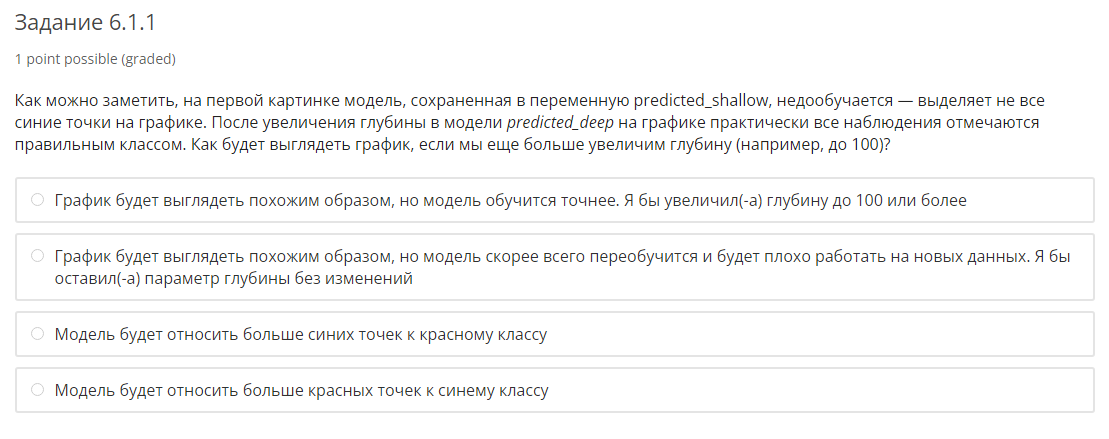

Вторая проблема со случайным лесом состоит в том, что процесс построения деревьев является ненаправленным: каждое следующее дерево в композиции никак не зависит от предыдущих. Из-за этого для решения сложных задач необходимо огромное количество деревьев.

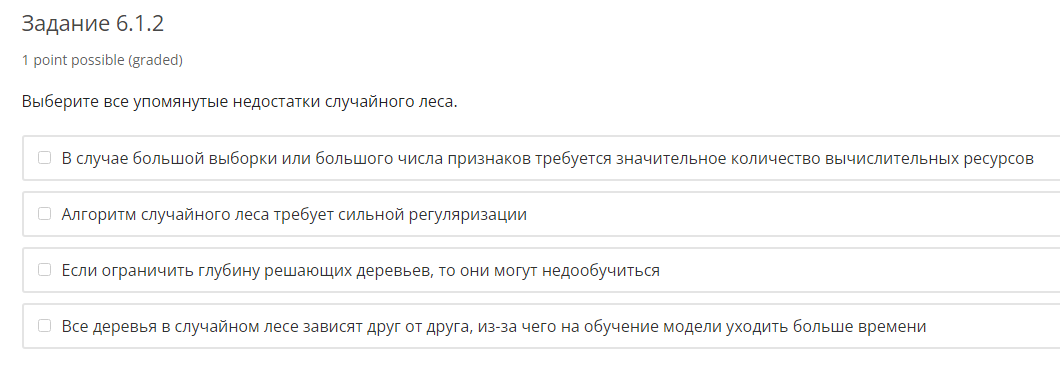

Итоги урока

В этом уроке мы вспомнили, что бэггинг и случайный лес строят композиции, независимо обучая каждый базовый алгоритм на некоторой подвыборке из обучающих данных. Однако можно предположить, что качество можно улучшить, если каждый алгоритм будет исправлять ошибки предыдущих. Эта идея реализована в градиентном бустинге, который мы рассмотрим в последующих занятиях.

# 6.2. AdaBoost
# ПРИМЕР
AdaBoost — итеративный алгоритм построения ансамбля. На каждой новой итерации строится дерево решений, корректирующее ответы всех предыдущих. Будем пробовать на каждой итерации разделить данные деревом глубины 1 (так называемым пнём). На первых двух итерациях мы увидим следующую картинку:
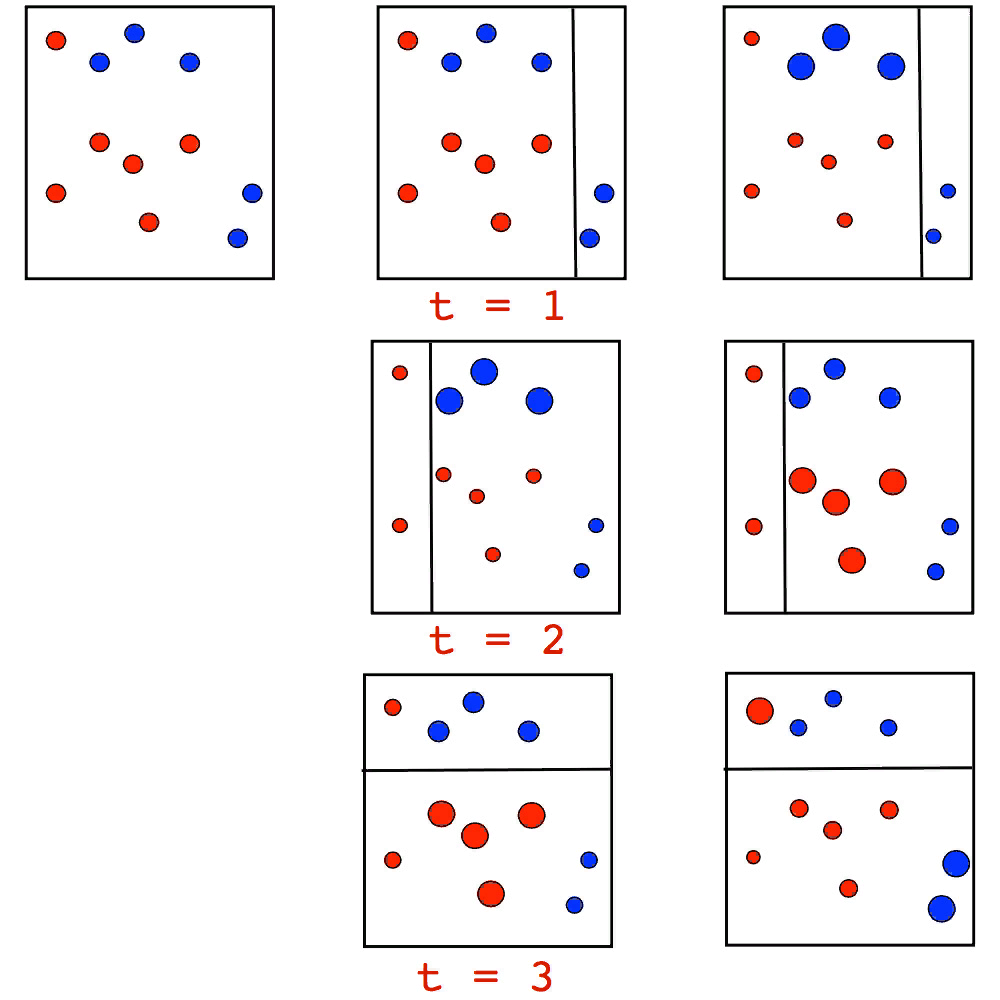
Размер точки соответствует полученному ей весу за ошибочное предсказание. Мы видим, как на каждой итерации эти веса растут — пни не могут в одиночку справиться с такой задачей. Однако, когда мы произведём взвешенное голосование ранее построенных пней, мы получим искомое нами разделение:
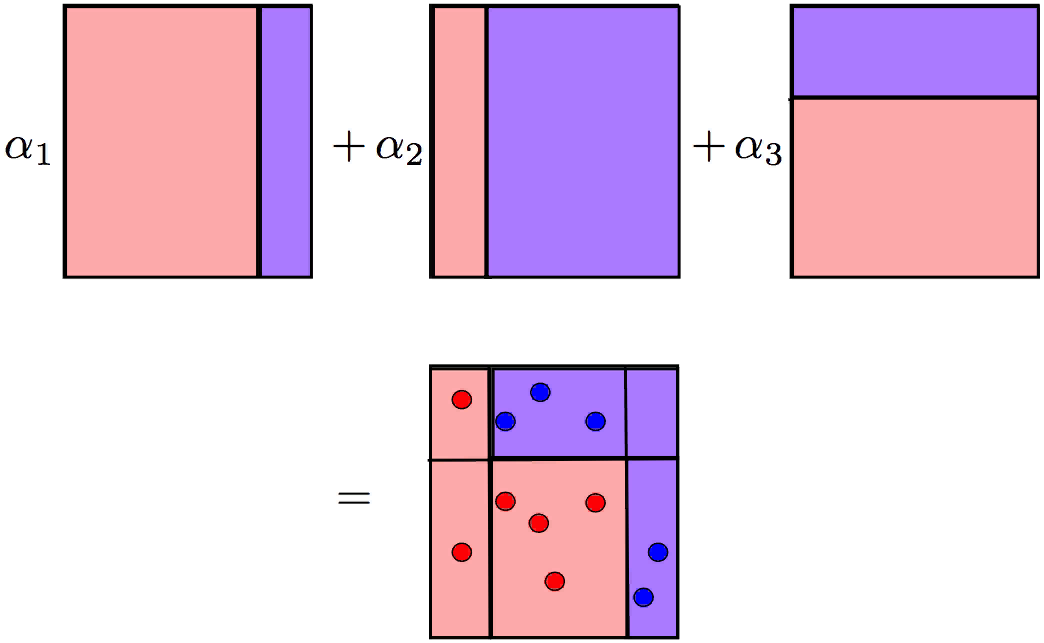
# АЛГОРИТМ
Первый ансамбль в этом разделе, который мы рассмотрим, называется AdaBoost (Adaptive Boosting). Бустинг позволяет из большого количества относительно слабых и простых моделей получить одну сильную. В нашем случае будут рассматриваться деревья решений ограниченной глубины.

Алгоритм построение AdaBoost:
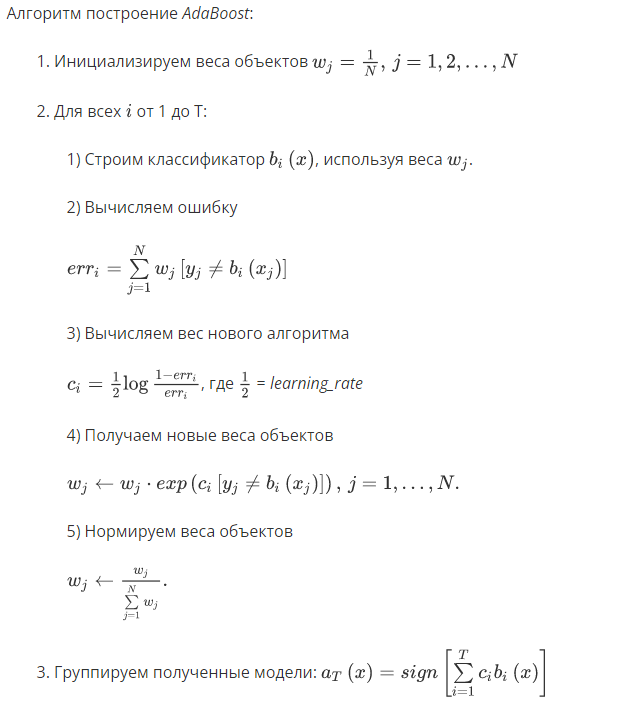
# ДОСТОИНСТВА
✔ Алгоритм прост.

✔ Накладные расходы бустинга минимальны. Время построения определяется временем построения базовых моделей.

✔ Показывает хорошую обобщающую способность.

✔ Имеет возможность идентификации шумовых объектов.

# НЕДОСТАТКИ
✖ Жадное добавление алгоритмов приводит к неоптимальности композиции.

✖ Склонен к переобучению при наличии шума в данных (опять же из-за экспоненциальной функции потерь).

✖ Переобучается при «малом» количестве данных.

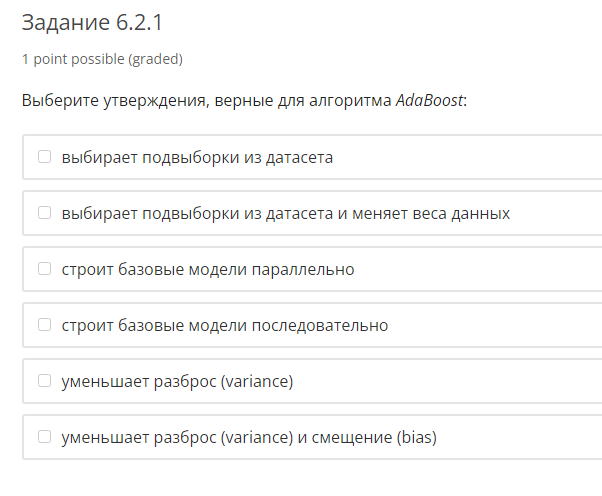

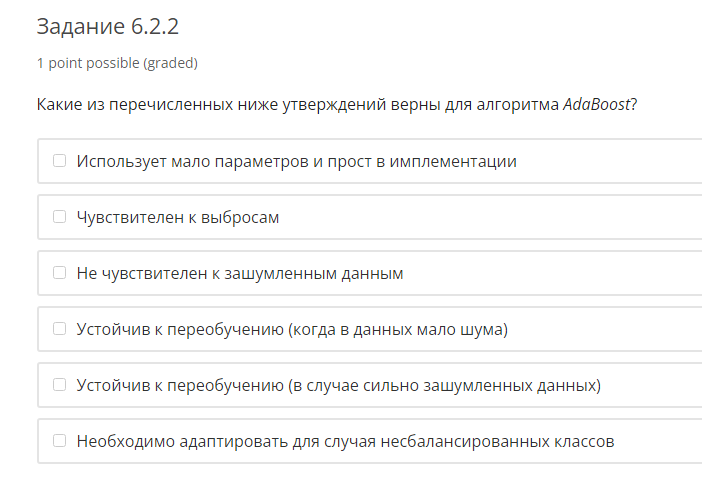

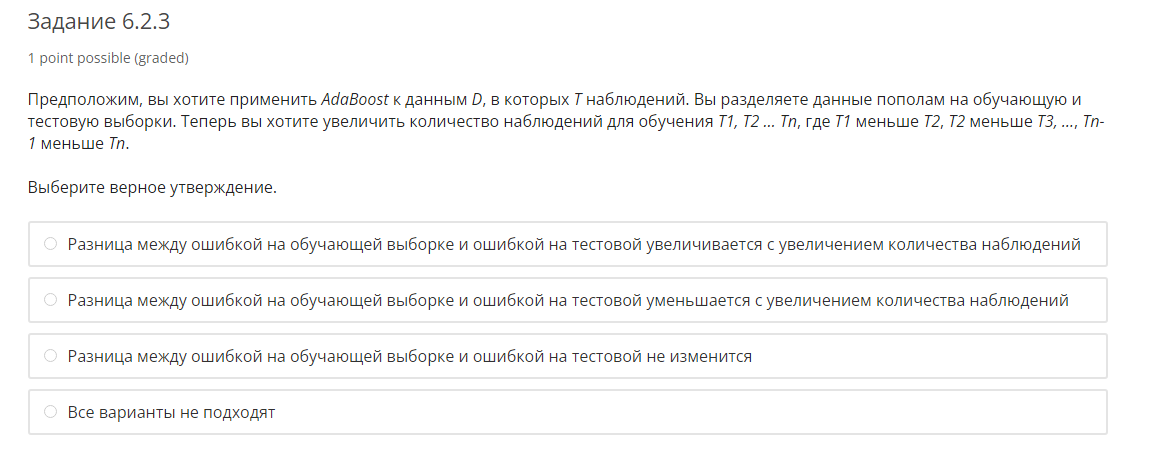

# 6.3. Градиентный бустинг
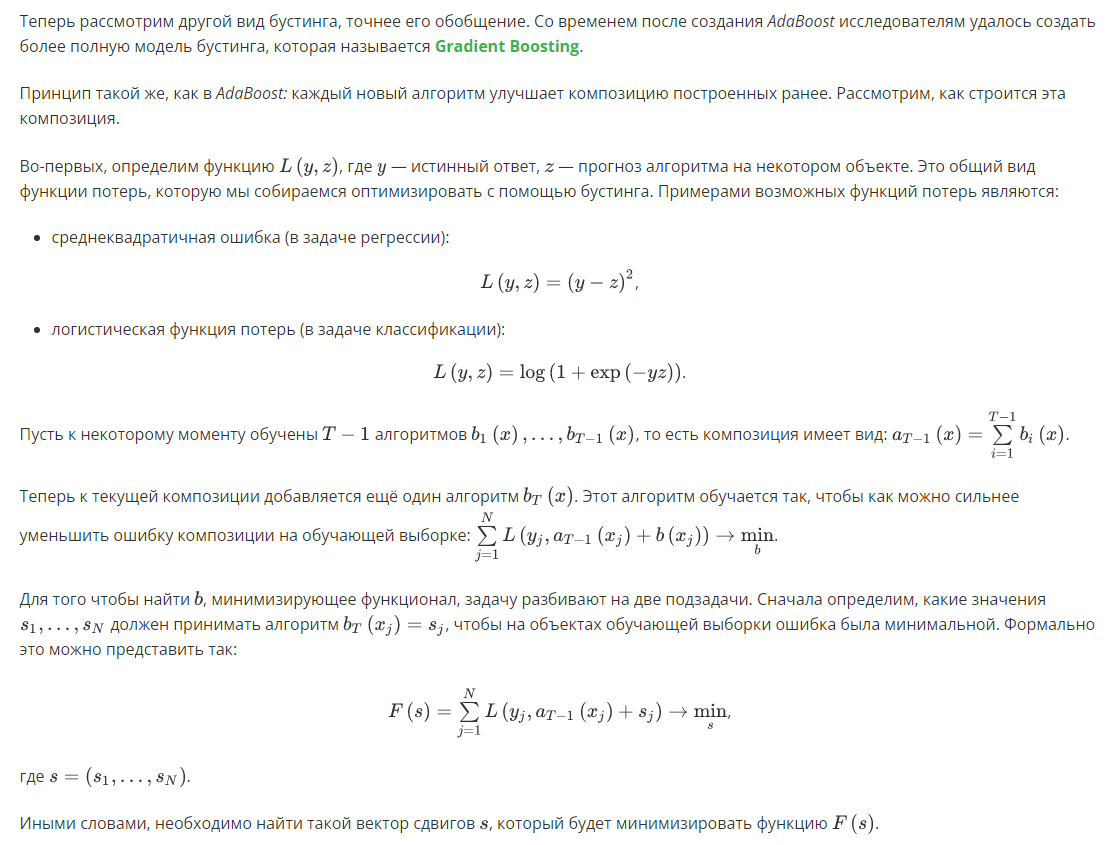
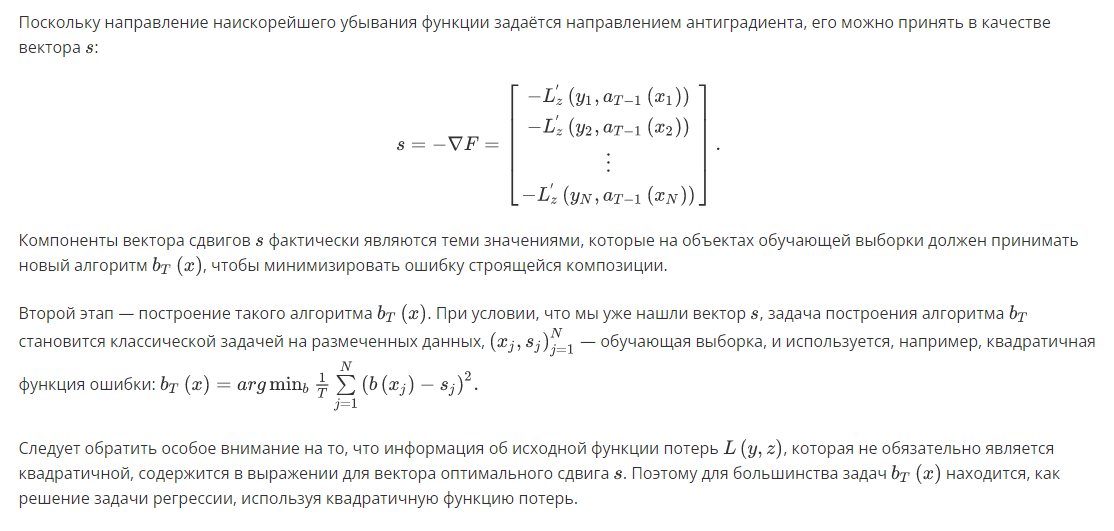
# АЛГОРИТМ
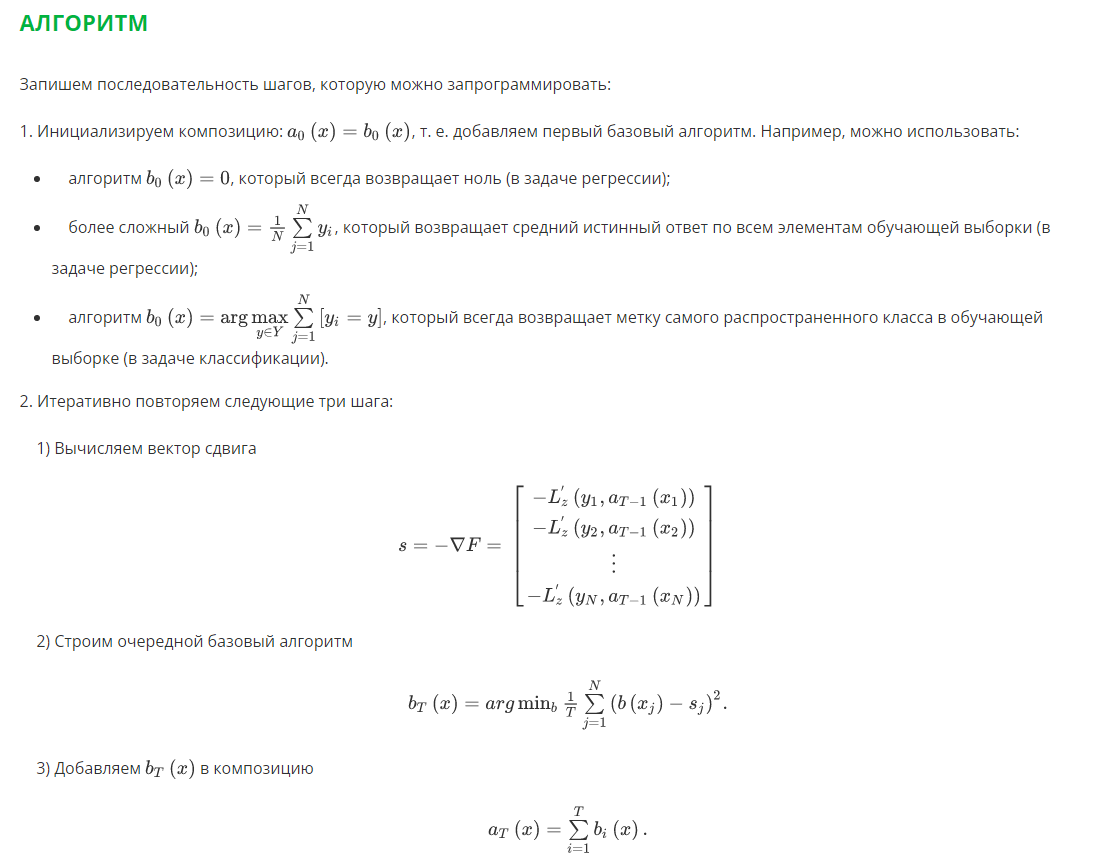
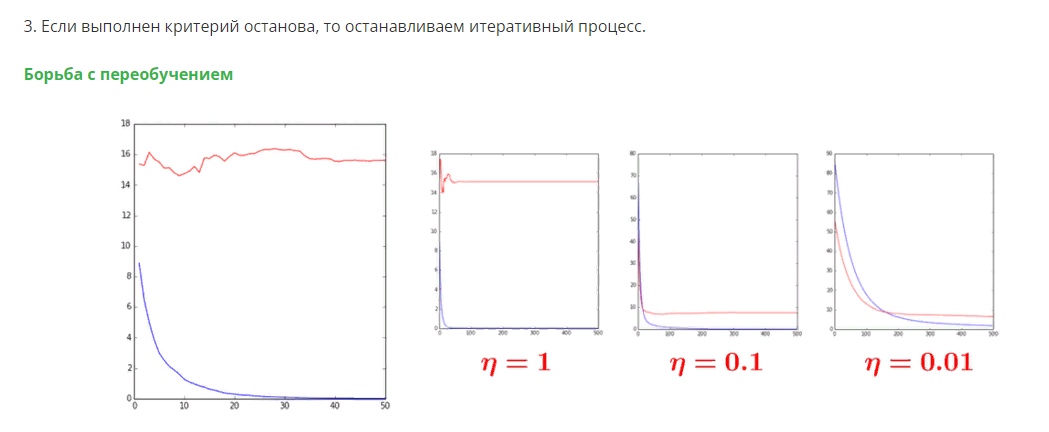

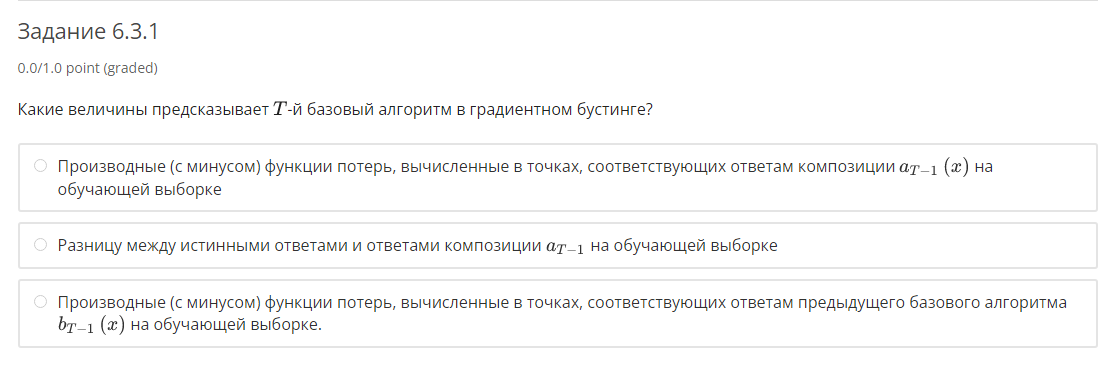

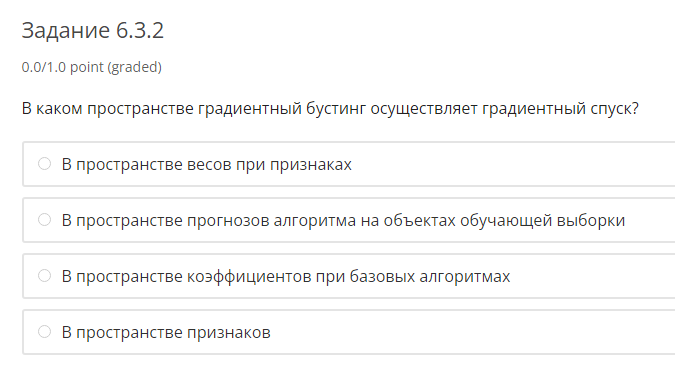

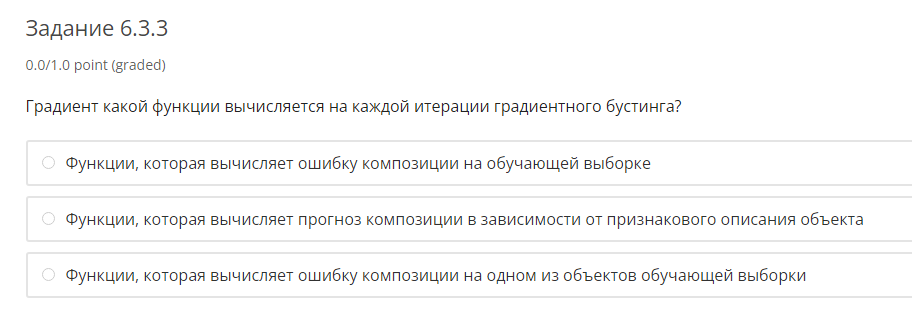

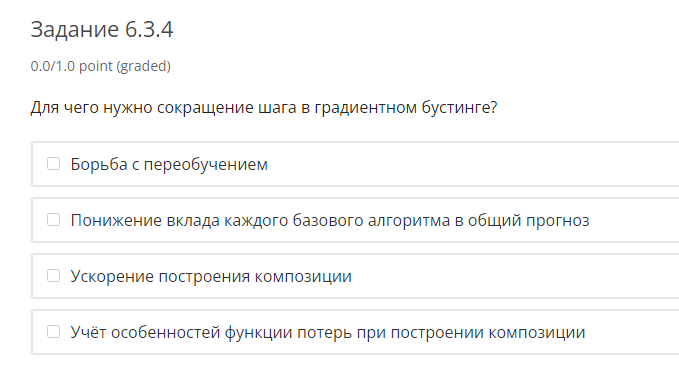

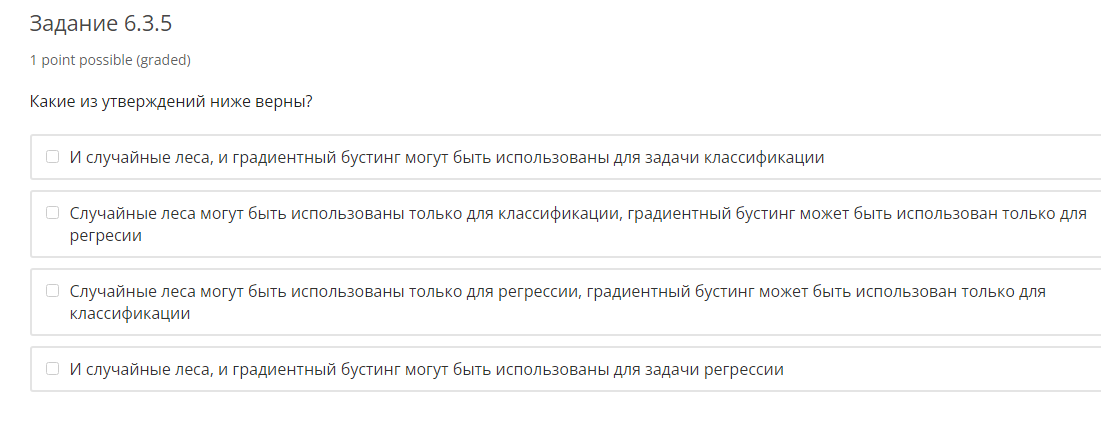

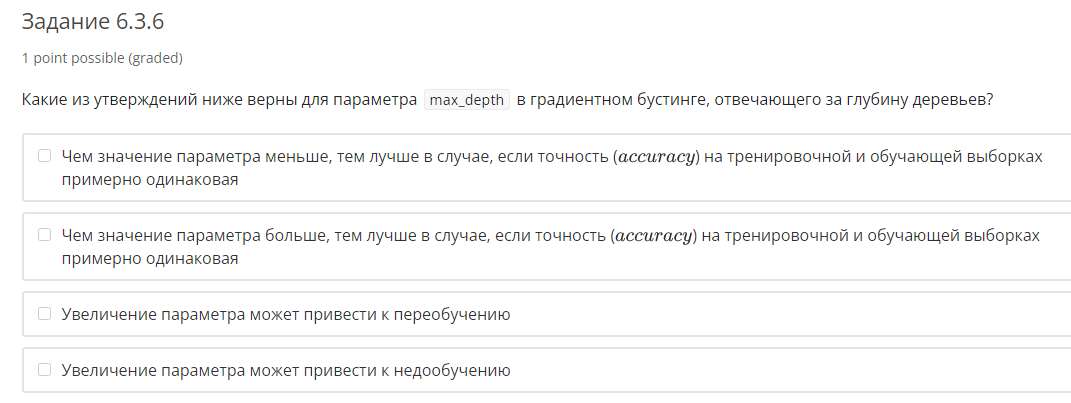

# 6.4. Бустинг. Практика
# Задание 6.4.1
Для решения первого задания урока сначала подготовим данные. Выкачаем набор данных, в котором будет прогнозировать, является ли письмо спамом.

Сделаем это следующим кодом:

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')

Также можно скачать данные здесь(https://lms.skillfactory.ru/assets/courseware/v1/e3d5c10692cf4e8cbca93742b89f6f94/asset-v1:Skillfactory+DST-WEEKLY-2.0+08JULY2020+type@asset+block/spam7.csv).

Из столбца yesno сделайте столбец spam, где 1 соответствует значению y (является спамом), а 0 – n (не является спамом). Удалите первый столбец (с индексом) и столбец "yesno".

Комбинации признаков должны иметь вид "признак1_признак2".

У Вас остается шесть столбцов-признаков и один столбец spam, который является нашей целевой переменной. Разделим их на x и у.

Теперь мы хотим создать новые признаки путем попарного перемножения уже имеющихся друг на друга. Сколько получится признаков после преобразования (включая те шесть, которые были в исходных данных)?
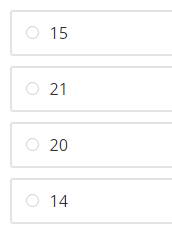

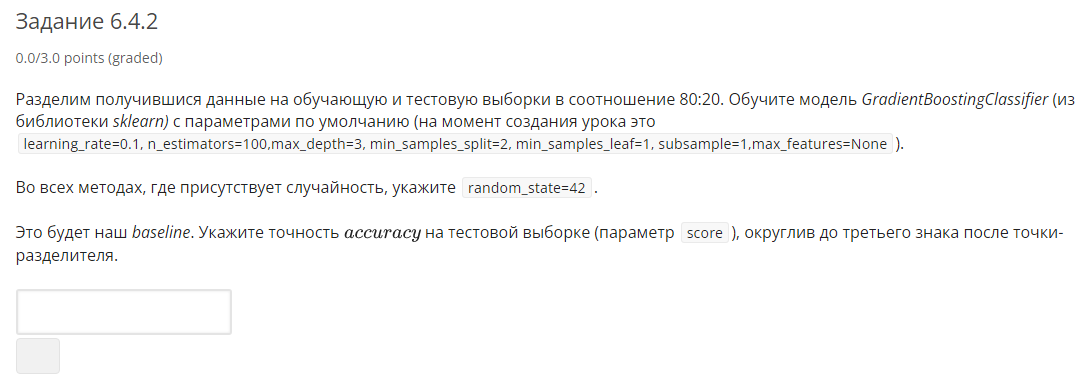

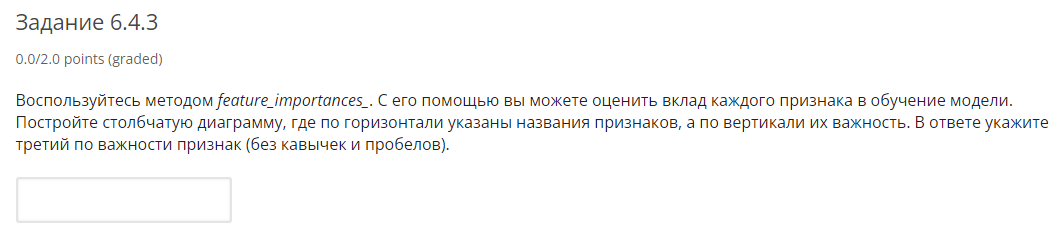

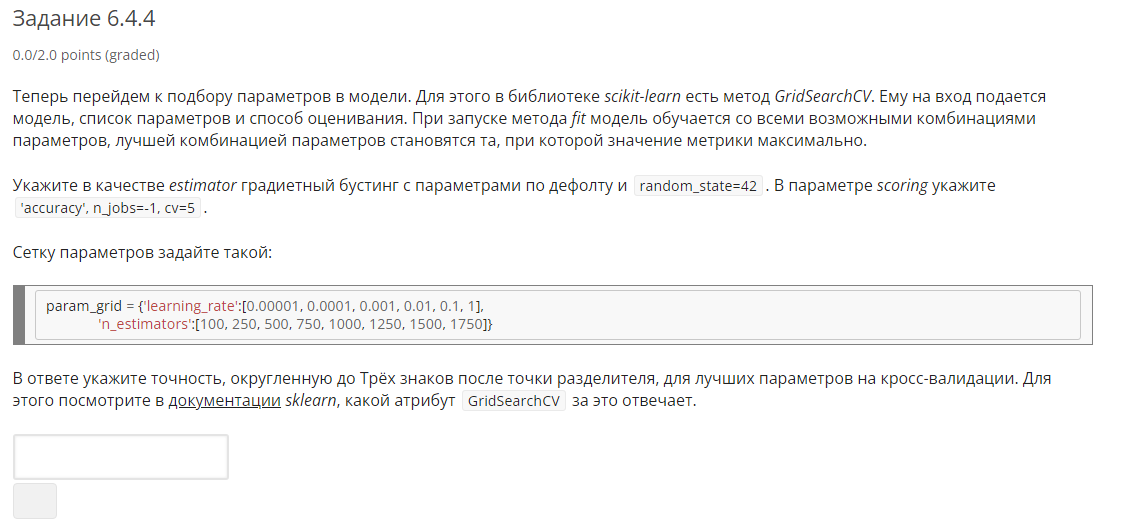

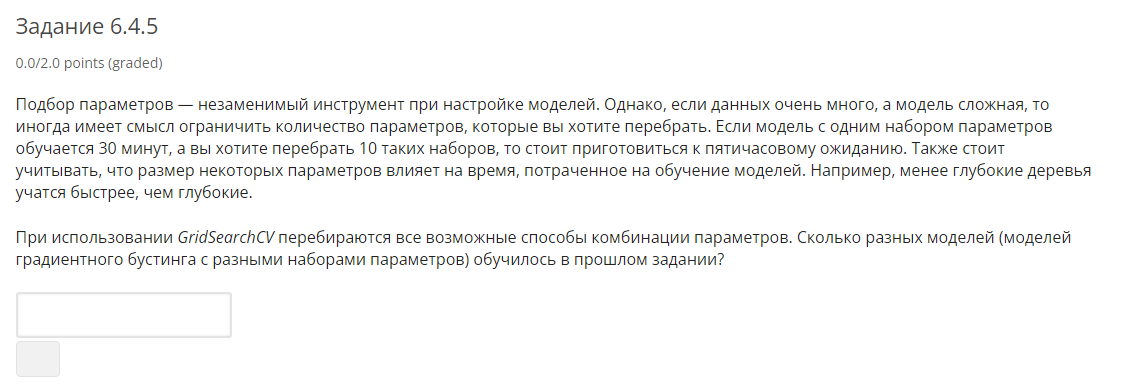

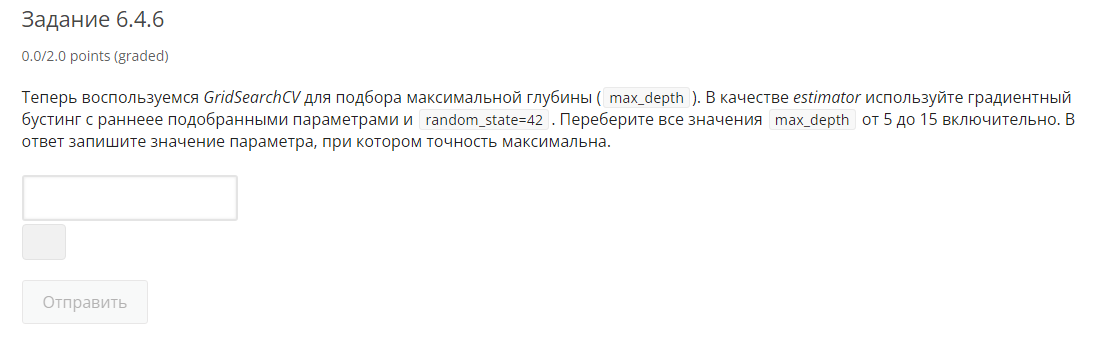

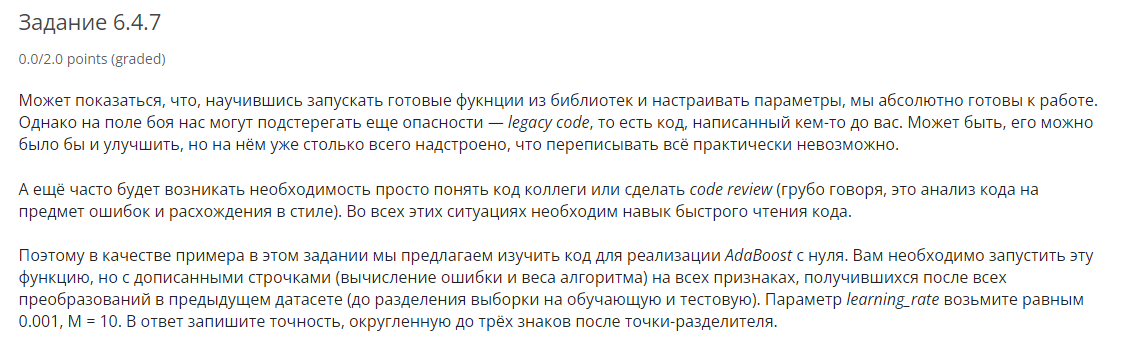
За основу нужно взять следующий код:

In [ ]:
# За основу нужно взять следующий код:
def AdaBoost_scratch(X,y, M=10, learning_rate =1):
    # инициалиазция служебных переменных
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    # инициализация весов
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    # цикл по длине М
    for m in range(M):   

        # обучим базовую модель и получим предсказание
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        # Маска для ошибок классификации
        incorrect = (y_predict != y)

        # Оцениваем ошибку
        #estimator_error = TODO 
        
        # Вычисляем вес нового алгоритма
        #estimator_weight =  TODO

        # Получаем новые веса объектов
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        # Сохраяем результаты данной итерации
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        


    # Для удобства переведем в numpy.array   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    # Получим предсказания
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X, y, M=10, learning_rate=0.001)

# ДОПОЛНИТЕЛЬНЫЕ МАТЕРИАЛЫ
В качестве дополнительного материала настоятельно рекомендуем послушать про CatBoost – градиентный бустинг от Яндекса: YouTube (https://www.youtube.com/watch?v=UYDwhuyWYSo)
Ещё один набирающий большую популярность метод — lightGBM. Предлагаем посмотреть лекцию про то, как с его помощью прогнозируют продажи в популярном магазине OZON. (https://www.youtube.com/watch?v=I4Oj17D8m04)

# 6.5. Стекинг
Стекинг (stacking) — агрегация ответов моделей машинного обучения при помощи ещё одной модели машинного обучения. Подход использует понятие базовых моделей, каждая из которых обучается независимо от остальных, и мета-модели, которая использует предсказания базовых моделей как признаки.

Правила стекинга:
- Обучать мета-модели нужно на новых для базовых моделей данных. Так избегается data leak, появляющийся при оценке алгоритмов на обучающей выборке.
- Можно использовать подходы из кросс-валидации (разбиение по фолдам, бутстрап) для получения различных моделей.
- Лучше применять регрессоры для мета-моделей.
- Для старта лучше взять простую мета-модель, например, линейную регрессию. В случае классификации — для агрегации вероятности классов. Этот частный случай называют блендингом (blending).
- Брать в качестве базовых моделей модели различной природы.
- Обучать модель не только на истинный таргет, но и на прокси таргет, например, на важный признак, который выявили во время исследования данных.
- Делать стекинг с большим количеством уровней при наличии достаточного количества данных, времени и усилий, что на практике редко.

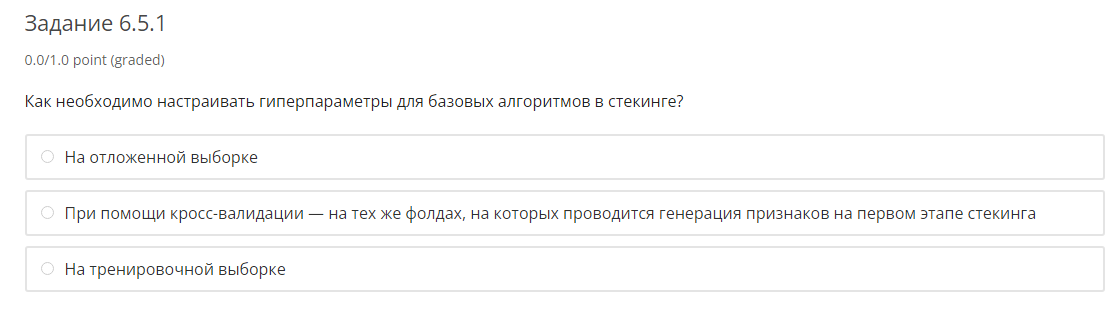

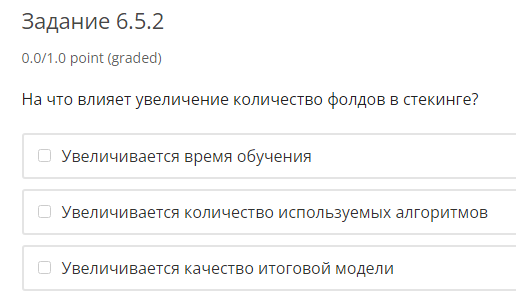

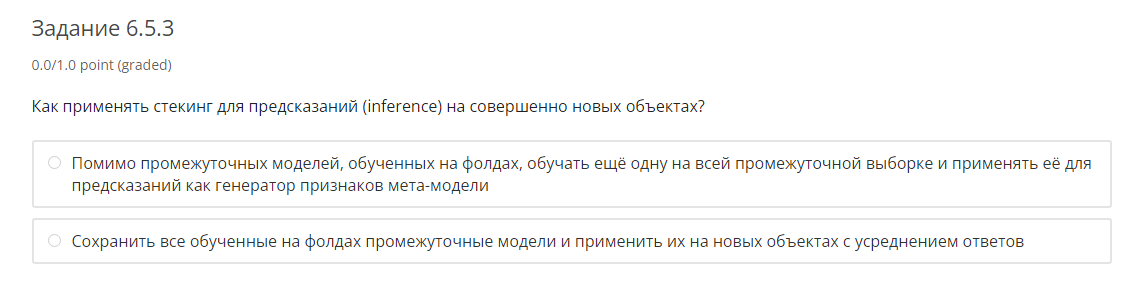

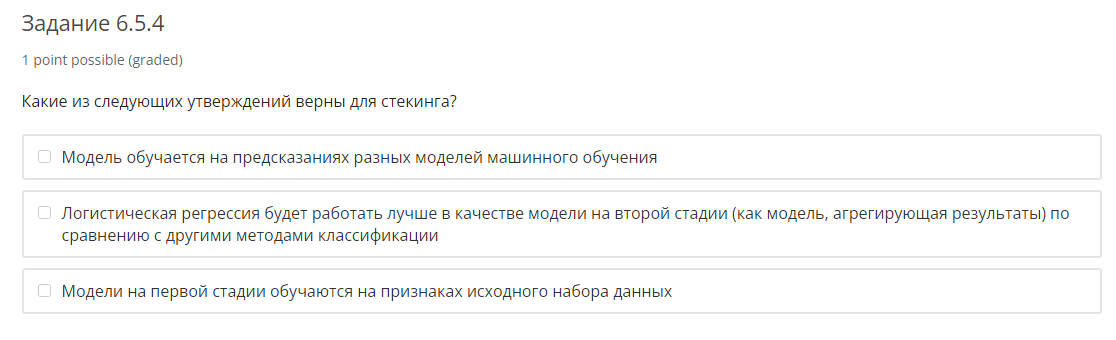

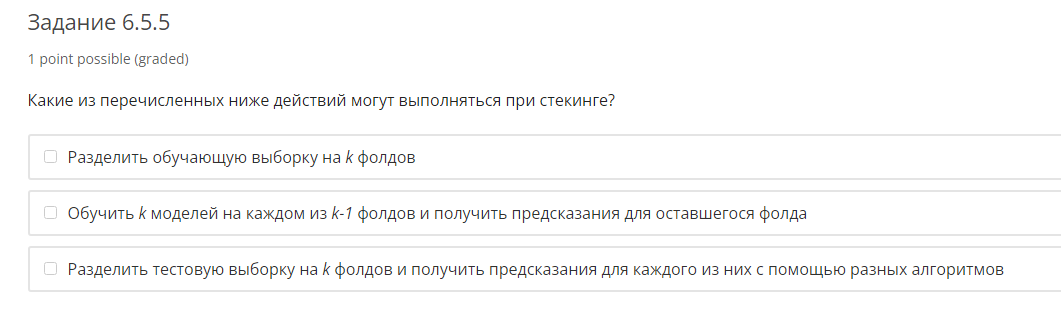

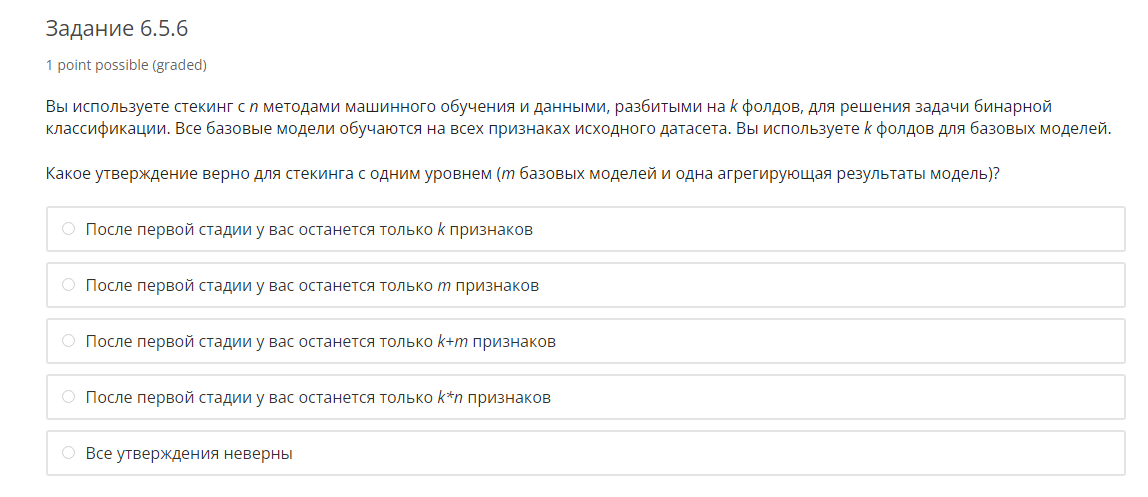

# 6.6. Стекинг. Практика
Разберём стекинг на практике, проанализировав датасет, описывающий параметры, которые были сняты со спутника при фотографировании Земли. У нас есть 54 переменные. Для упрощения будем рассматривать два типа поверхностей —так мы сводим нашу задачу к задаче бинарной классификации. Сделаем базовую предобработку, воспользуемся StandardScaler.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

Стекинг позволяет объединять ответы нескольких алгоритмов первого уровня в один большой ответ при помощи нового алгоритма обучения. Для избежания переобучения будем разбивать обучающую выбоку на фолды — разбиение обучающей выборки на несколько частей. На каждом фолде мы обучаем алгоритм заново.

Функция compute_meta_feature принимает на вход один алгоритм и возвращает новые признаки на объектах, которые не использовались во время обучения. Функция generate_meta_feature делает подобное, но принимает на вход несколько классификаторов в списке и повторяет процедуру, а затем генерирует и возвращает матрицу с изначальным количеством объектов, признаков будет столько, сколько мы передали классификаторов. 

In [ ]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
    
    return X_meta_train, X_meta_test

def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

Обучим один градиентный бустинг, в котором будем использовать 300 алгоритмов. Мы получим accuracy = 0.7899929527836504. Если мы будем агрегировать бустинг со случайным лесом и с двумя логистическими регрессиями, то получим результат лучше: 0.8118393234672304.

 НОУТБУК К СКРИНКАСТУ
https://lms.skillfactory.ru/assets/courseware/v1/452ada220fe59532217dd62eaf6786a3/asset-v1:Skillfactory+DST-WEEKLY-2.0+08JULY2020+type@asset+block/m6_5_Практика.ipynb

Все задания выполняются на основе датасета:

In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.datasets import load_digits

from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import randint

dataset = load_digits()
X, y = dataset['data'], dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

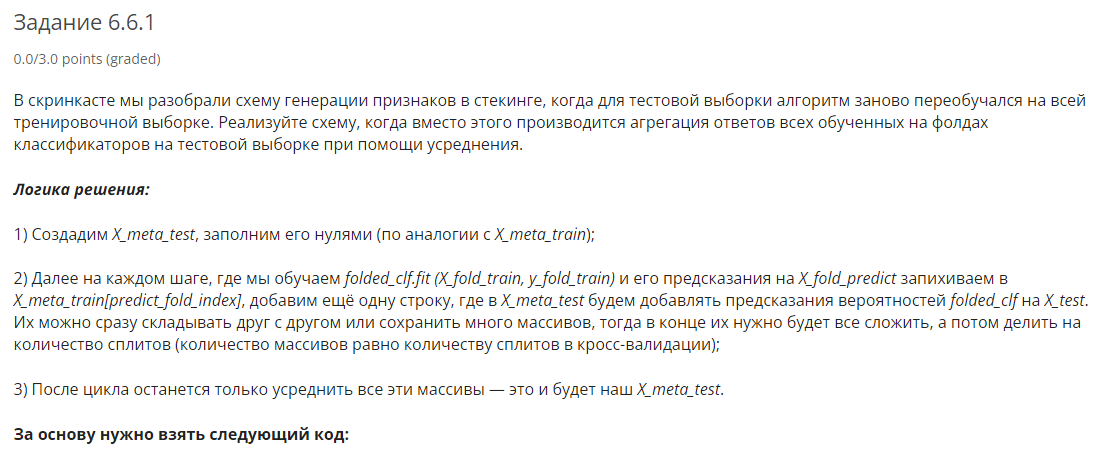

In [2]:
# За основу нужно взять следующий код:
def compute_meta_feature_mean(clf, X_train, X_test, y_train, cv):
    """    Эта функция подсчитывает признаки для мета-классификатора.     Они являются вероятностями классов при решении задачи многоклассовой классификации.    :arg clf: классификатор    :args X_train, y_train: обучающая выборка    :arg X_test: признаки тестовой выборки    :arg cv: класс, генерирующий фолды (KFold)    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок    """
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(X_train), n_classes), dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)

    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)

    X_meta_test = meta_clf.predict_proba(X_test)

    return X_meta_train, X_meta_test

In [3]:
def compute_meta_feature_mean(clf, X_train, X_test, y_train, cv):
    """
    Эта функция подсчитывает признаки для мета-классификатора. 
    Они являются вероятностями классов при решении задачи многоклассовой классификации.

    :arg clf: классификатор
    :args X_train, y_train: обучающая выборка
    :arg X_test: признаки тестовой выборки
    :arg cv: класс, генерирующий фолды (KFold)

    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок
    """
# Напишите ваш код ниже

In [ ]:
# Для следующих заданий используйте этот код:

def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test
cv = KFold(n_splits=10, shuffle=True, random_state=42)

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(f1_score(y_test, y_test_pred, average='macro'), 6)

ПОДСКАЗКА
- Во всех случаях, когда модель принимает random_state — обязательно указывайте его равным 42
- На разных версиях sklearn ответы могут отличаться
- В задании может понадобиться, а может не понадобиться нормализация и это нужно проверить во время решения задания.

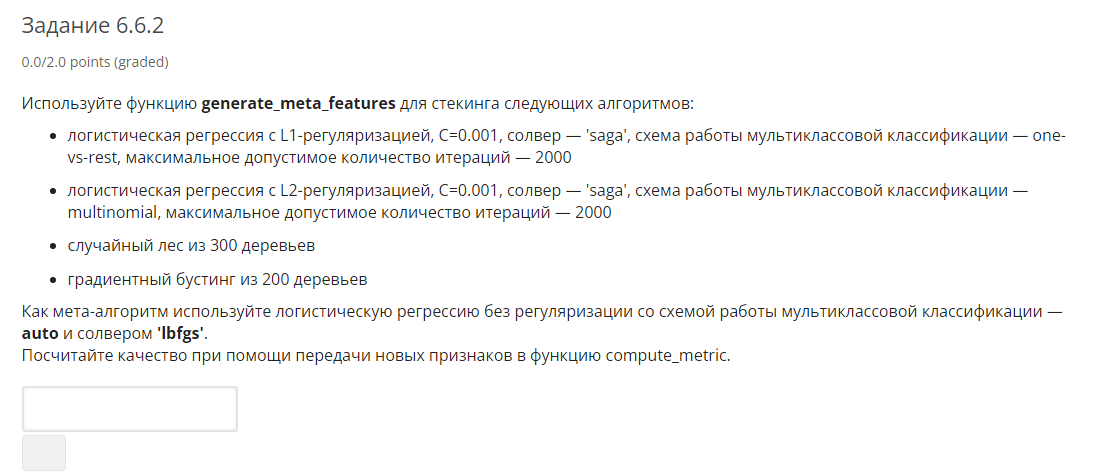

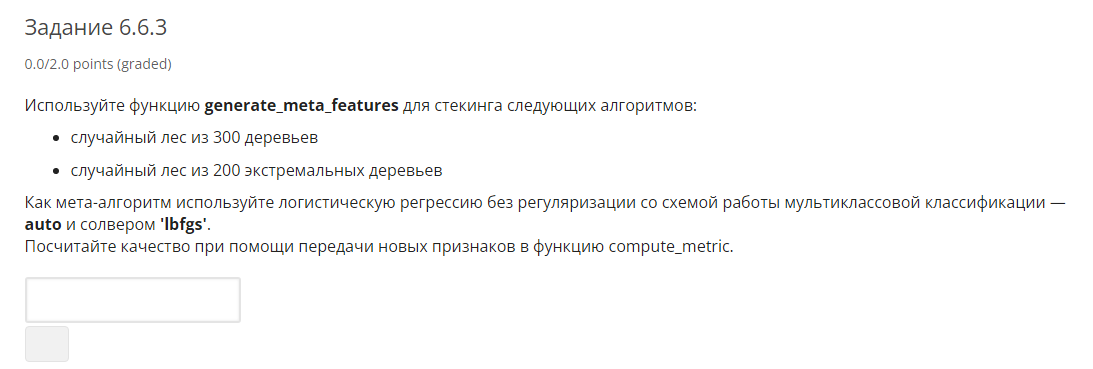

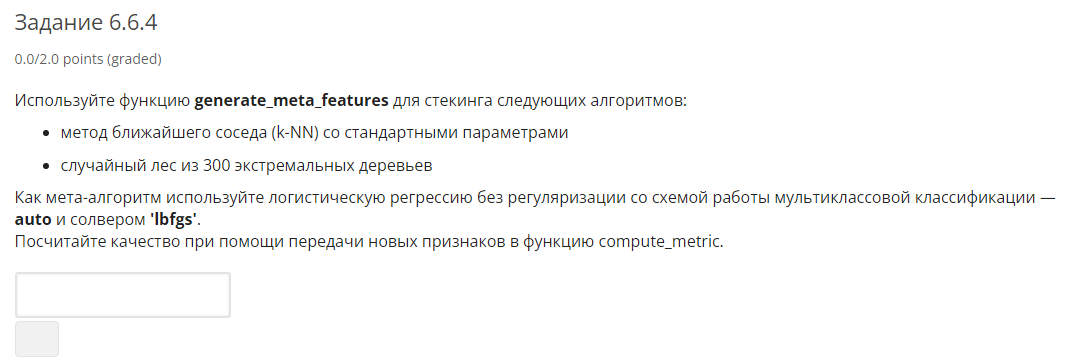

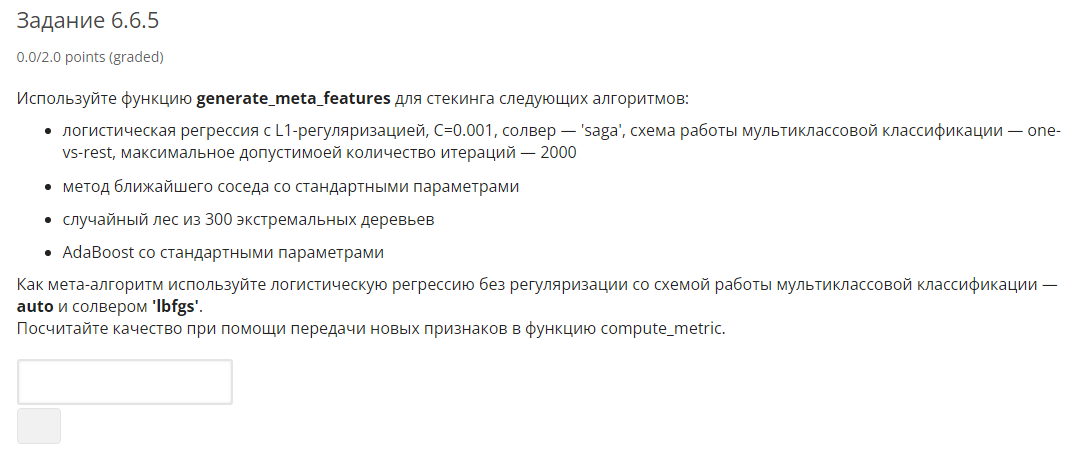

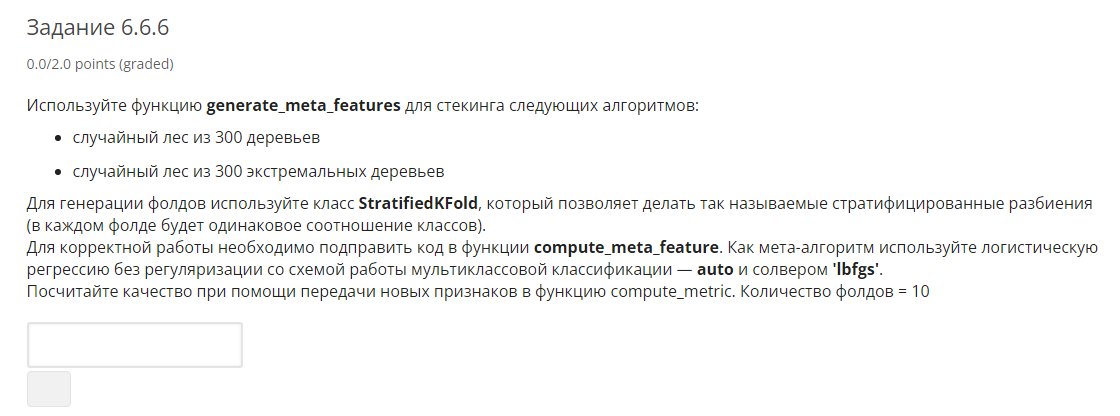

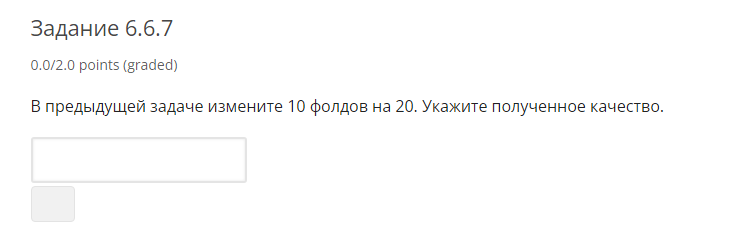

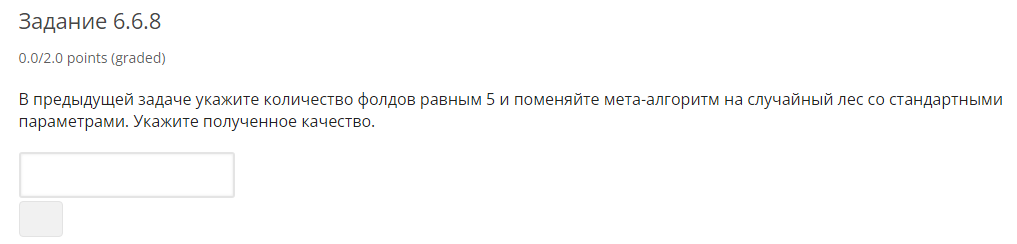

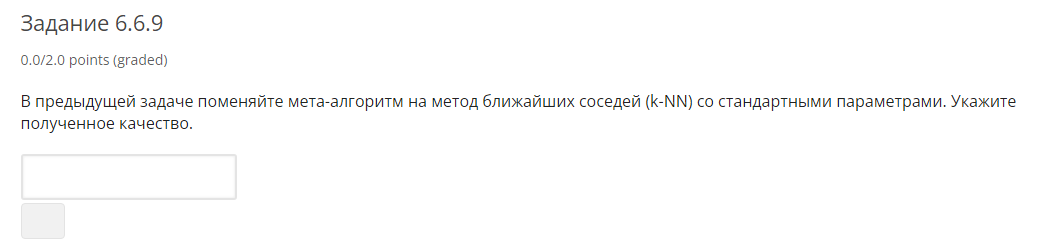

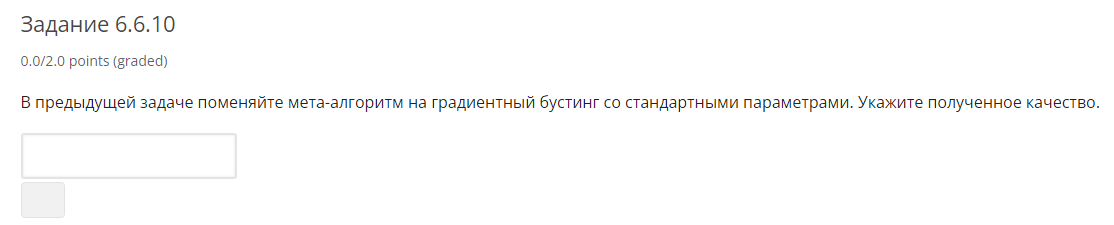

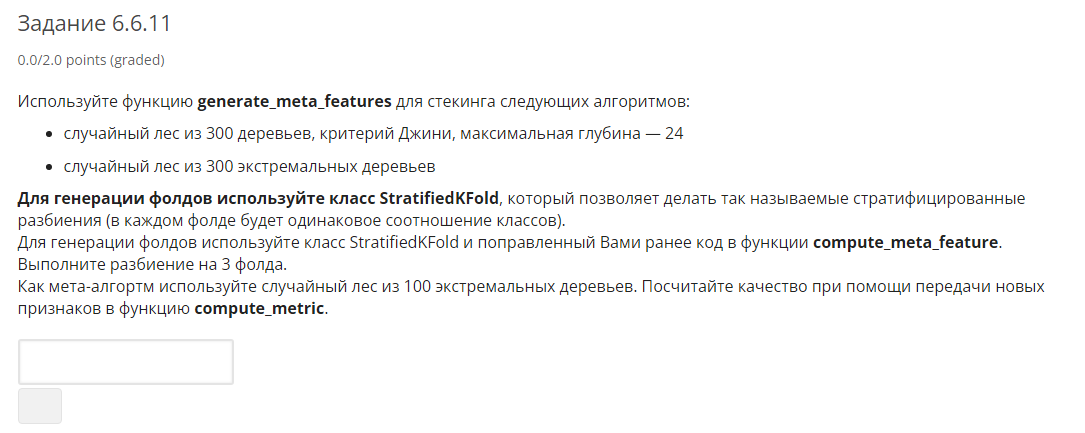

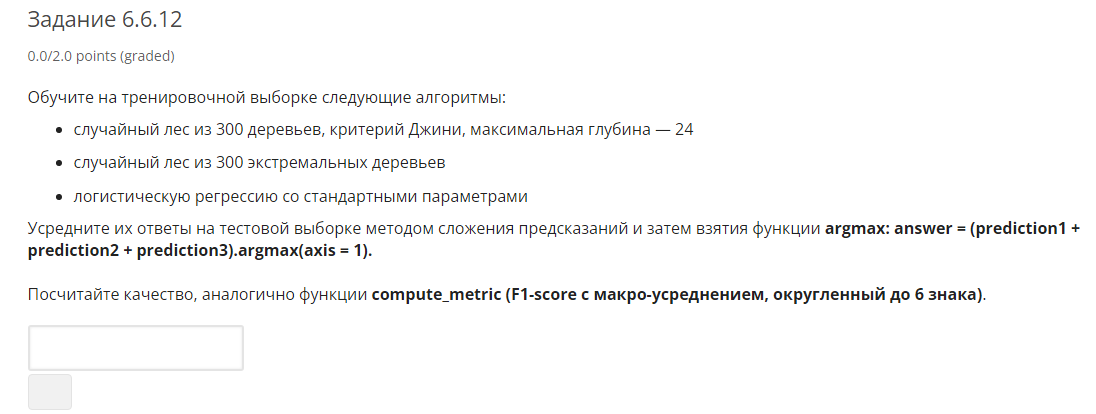

# 6.7. Готовимся к собеседованию
В этом уроке мы немного освежим знания по прошедшему модулю. Вопросы такого типа вполне могут быть и на собеседовании, а также просто важны для понимания работы алгоритмов. Мы рекомендуем сначала попробовать ответить на все вопросы ниже по памяти, а потом повторить пройденный материал по вопросам, в которых были ошибки или сомнения.

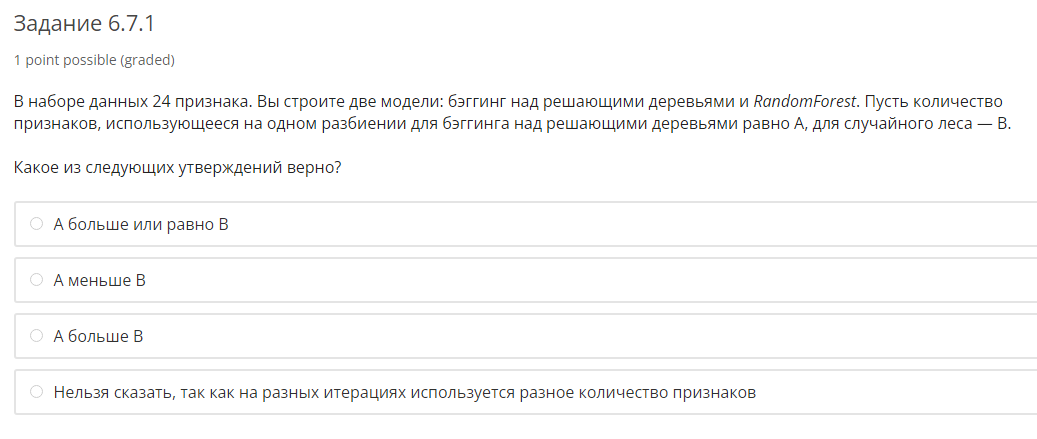

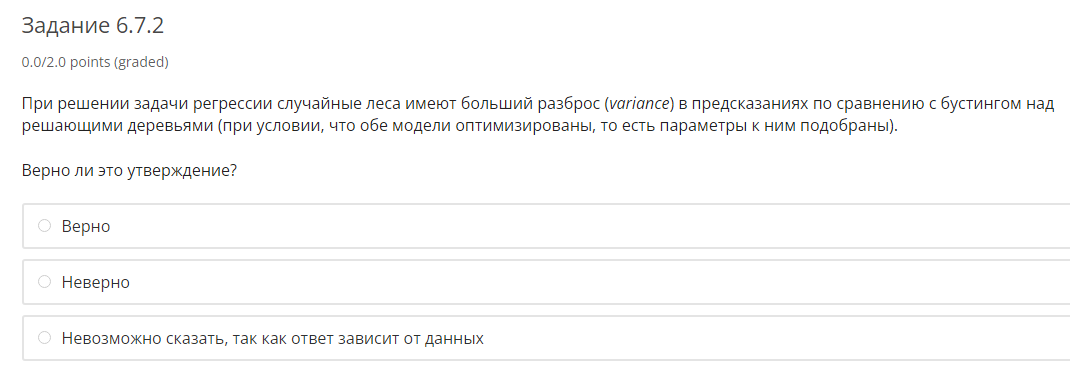

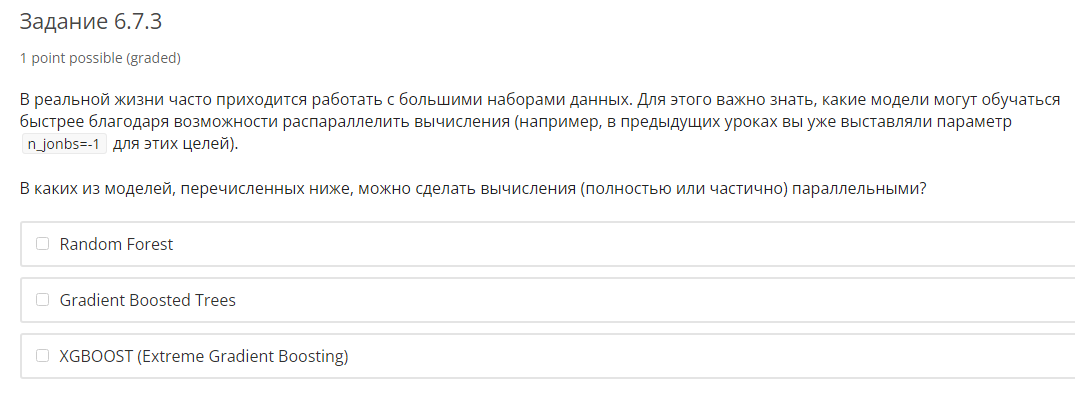

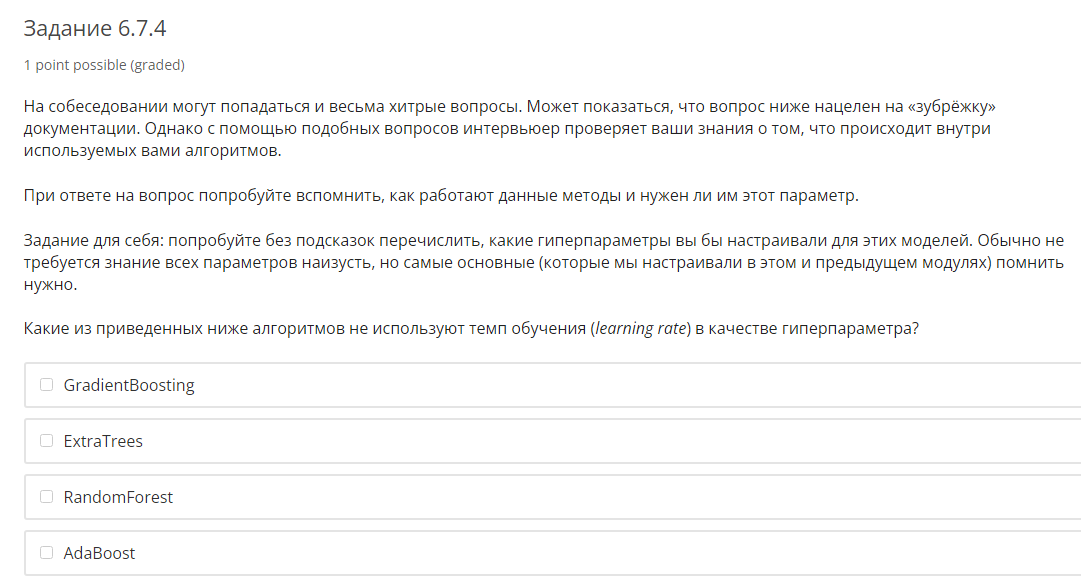

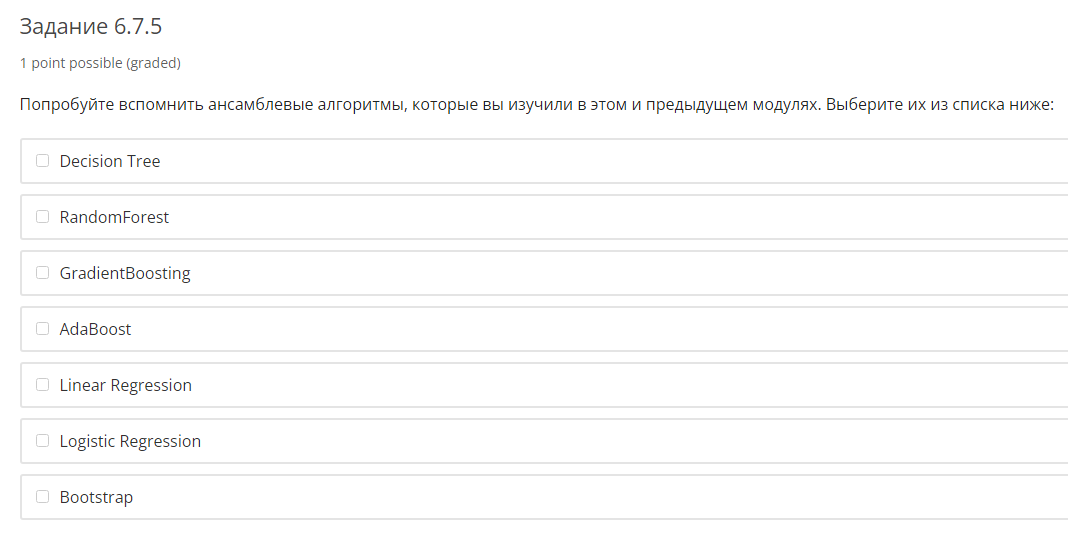

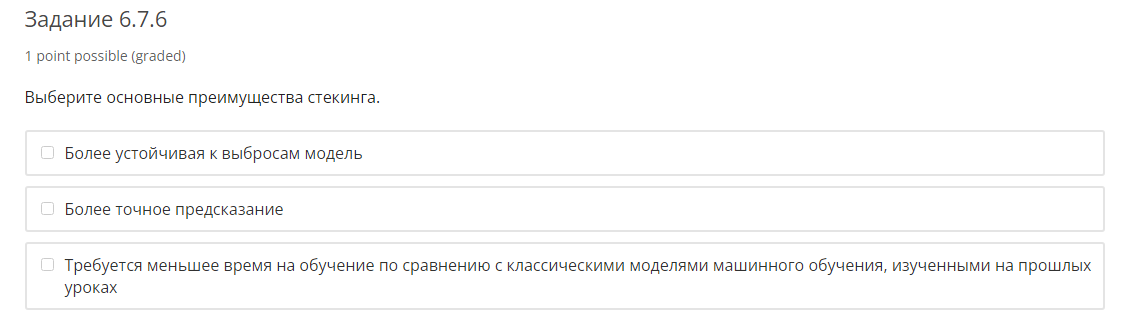